In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import SGD,AdamW
from torch import nn

In [2]:
import utils_generic as generic
import rrnn_st as rrnn
import model_confs as confs


import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)

# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_rrnn(convai_train,['about','to','as'],word_to_index) 
convai_val_token = generic.tokenize_dataset_rrnn(convai_val,['about','to','as'],word_to_index) 

In [6]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskSimple(convai_train_token,task,eval=False)

In [7]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskSimple(convai_val_token,task,eval=False)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_rrnn(md_data,['about','to','as'],word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskSimple(md_tokenized,task,eval=True)

# Creación dataloaders

In [10]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn)

In [11]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn)

In [12]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn)

# ABOUT

In [13]:
emb_dim = 20
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

In [14]:
model = rrnn.SingleTaskRRNN(emb_dim,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_about_adam'

In [15]:
for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5242346938775511 

Using scikit learn accuracy por género en el conjunto about
MALE 0.10416666666666667
FEMALE 0.9275 

GLOBAL: 0.476010101010101 

Using scikit learn accuracy por género en el conjunto to
MALE 0.0535279805352798
FEMALE 0.931758530183727 

GLOBAL: 0.4954367666232073 

Using scikit learn accuracy por género en el conjunto as
MALE 0.07828282828282829
FEMALE 0.9407008086253369 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6808125703800015 	 Validation loss: 0.6823276261151847 	 
  1%|          | 574/57400 [00:04<07:02, 134.45it/s]
Epoch 2 	 Training loss: 0.6723699140839461 	 Validation loss: 0.6699661945892592 	 
  2%|▏         | 1148/57400 [00:09<07:05, 132.15it/s]
Epoch 3 	 Training loss: 0.6633250828611726 	 Validation loss: 0.6631678494356447 	 
  3%|▎         | 1722/57400 [00:13<06:45, 137.28it/s]
Epoch 4 	 Training loss: 0.656726219305178 	 Validation loss: 0.6593856225579472 	 
  4%|▍         | 2296/57400 [00:18<06:44, 136.15it/s]
Epoch 5 	 Training loss: 0.6492859274668146 	 Validation loss: 0.6507215166496019 	 
  5%|▌         | 2870/57400 [00:22<06:44, 134.65it/s]
Epoch 6 	 Training loss: 0.6419269011618783 	 Validation loss: 0.6427376209679296 	 
  6%|▌         | 3444/57400 [00:26<06:31, 137.73it/s]
Epoch 7 	 Training loss: 0.6340188970756863 	 Validation loss: 0.637161434706995 	 
  7%|▋         | 4018/57400 [00:31<06:23, 139.35it/s]
Epoch 8 	 Training loss: 0.626

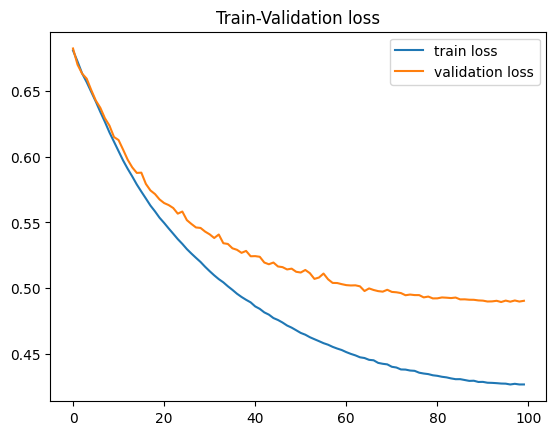

In [16]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [17]:
model = rrnn.SingleTaskRRNN(emb_dim,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.6709183673469388 

Using scikit learn accuracy por género en el conjunto about
MALE 0.5703125
FEMALE 0.7675 

GLOBAL: 0.5176767676767676 

Using scikit learn accuracy por género en el conjunto to
MALE 0.35036496350364965
FEMALE 0.6981627296587927 

GLOBAL: 0.5788787483702738 

Using scikit learn accuracy por género en el conjunto as
MALE 0.4393939393939394
FEMALE 0.7277628032345014 



# TO

In [18]:
emb_dim = 20
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

In [19]:
model = rrnn.SingleTaskRRNN(emb_dim,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_to_adam'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6931970367655936 	 Validation loss: 0.6922058826785976 	 
  1%|          | 574/57400 [00:04<07:36, 124.58it/s]
Epoch 2 	 Training loss: 0.6931468168409859 	 Validation loss: 0.6924275947829425 	 
  2%|▏         | 1148/57400 [00:09<07:41, 121.84it/s]
Epoch 3 	 Training loss: 0.6932109605767586 	 Validation loss: 0.6934576580079935 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:14<07:22, 125.78it/s]
Epoch 4 	 Training loss: 0.6930772281066881 	 Validation loss: 0.6932250695713496 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:19<07:02, 130.53it/s]
Epoch 5 	 Training loss: 0.6930900263869388 	 Validation loss: 0.693090240834123 	 
  5%|▌         | 2870/57400 [00:24<06:58, 130.20it/s]
Epoch 6 	 Training loss: 0.693017603212948 	 Validation loss: 0.6931327844070176 	 
  6%|▌         | 3444/57400 [00:29<07:03, 127.49it/s]
Epoch 7 	 Training loss: 0.6930331590906669 	 Validation loss: 0.6929431658680156 	 
  7%|▋         | 4018/5740

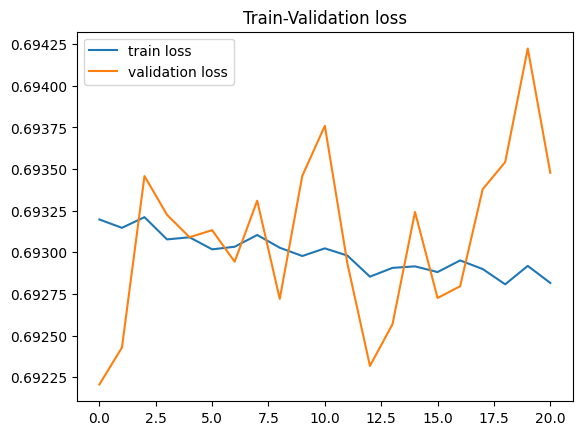

In [20]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [21]:
model = rrnn.SingleTaskRRNN(emb_dim,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5102040816326531 

Using scikit learn accuracy por género en el conjunto about
MALE 0.0
FEMALE 1.0 

GLOBAL: 0.4797979797979798 

Using scikit learn accuracy por género en el conjunto to
MALE 0.0
FEMALE 0.9973753280839895 

GLOBAL: 0.48370273794002605 

Using scikit learn accuracy por género en el conjunto as
MALE 0.0025252525252525255
FEMALE 0.9973045822102425 



# AS

In [22]:
model = rrnn.SingleTaskRRNN(emb_dim,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_as_adam'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932431012911249 	 Validation loss: 0.6932599544525146 	 
  1%|          | 574/57400 [00:03<04:57, 191.21it/s]
Epoch 2 	 Training loss: 0.6932074328955873 	 Validation loss: 0.6927326018527403 	 
  2%|▏         | 1148/57400 [00:06<04:53, 191.72it/s]
Epoch 3 	 Training loss: 0.693152696724968 	 Validation loss: 0.6930226542181888 	 
  3%|▎         | 1722/57400 [00:09<04:49, 192.21it/s]
Epoch 4 	 Training loss: 0.6930447481442827 	 Validation loss: 0.6937832296904871 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:13<04:53, 187.75it/s]
Epoch 5 	 Training loss: 0.6930703096065787 	 Validation loss: 0.6932137396376011 	 
  5%|▌         | 2870/57400 [00:16<04:46, 190.18it/s]
Epoch 6 	 Training loss: 0.6930446828283915 	 Validation loss: 0.6931968745538744 	 
  6%|▌         | 3444/57400 [00:19<04:42, 191.09it/s]
Epoch 7 	 Training loss: 0.6929221784611612 	 Validation loss: 0.6933057873936023 	 
  7%|▋         | 4018/57400 [00:22<04:43, 188.05it/s]


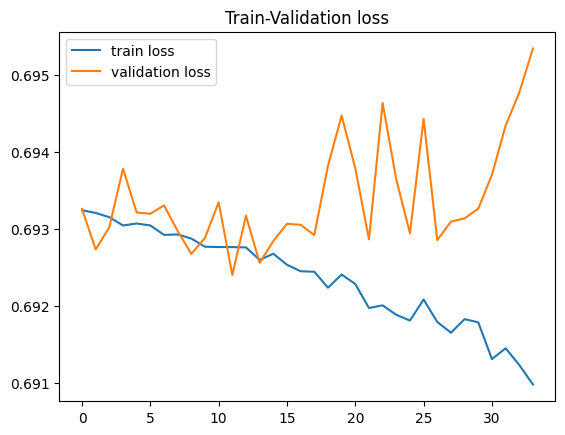

In [23]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [24]:
model = rrnn.SingleTaskRRNN(emb_dim,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.46683673469387754 

Using scikit learn accuracy por género en el conjunto about
MALE 0.734375
FEMALE 0.21 

GLOBAL: 0.5113636363636364 

Using scikit learn accuracy por género en el conjunto to
MALE 0.7883211678832117
FEMALE 0.2125984251968504 

GLOBAL: 0.5228161668839635 

Using scikit learn accuracy por género en el conjunto as
MALE 0.8080808080808081
FEMALE 0.2183288409703504 

